Developing a script to download all WPQs into a csv, and subsequently to update that CSV. 

In [2]:
import requests
import json
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()
import os
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# tmp = 'Users/ben/Documents/blog/UKParliament/tmp/'

In [4]:
active_p = pd.read_csv('active_members.csv')
former_p = pd.read_csv('former_members.csv')

In [4]:
all_p = pd.concat([active_p, former_p])
all_p = all_p[['id', 'nameListAs', 'gender', 'latestPartyabbreviation']]

In [5]:
all_p[all_p.id == 4356]

,id,nameListAs,gender,latestPartyabbreviation
437,4356,"Rayner, Angela",F,Lab


In [6]:
id_party_dict = dict(zip(all_p.id, all_p.latestPartyabbreviation))

In [7]:
wpqs = pd.read_csv('/Users/ben/Documents/blog/pqs/tmp/pqs.csv')
wpqs['dateAnswered'] = pd.to_datetime(wpqs.dateAnswered)
wpqs['heading'] = wpqs.heading.fillna('')
wpqs = wpqs[['id', 'askingMemberId', 'askingMember', 'house', 'dateAnswered', 'questionText', 'answeringBodyName', 'answerText', 'heading']]

# Populate a column with party appreviation in the WPQs database
wpqs['latestPartyabbreviation'] = wpqs.askingMemberId.progress_apply(lambda x: id_party_dict[x] if x in id_party_dict.keys() else 'n/a')

100%|██████████| 391132/391132 [00:00<00:00, 1351696.09it/s]


In [8]:
wpqs['heading'] = wpqs.heading.progress_apply(lambda x: x.lower())
wpqs['answerText'] = wpqs.answerText.progress_apply(lambda x: x.lower())
wpqs['questionText'] = wpqs.questionText.progress_apply(lambda x: x.lower())

100%|██████████| 391132/391132 [00:00<00:00, 999614.00it/s] 


In [9]:
# Sometime the heading is a generic topic, other times it's specified by a ":" symbol. We'll extract this into a 'topic' column.
wpqs['topic'] = wpqs.heading.progress_apply(lambda x: x.split(':')[0])

100%|██████████| 391132/391132 [00:00<00:00, 1321710.19it/s]


In [10]:
wpqs['year'] = wpqs.dateAnswered.dt.year

In [11]:
wpqs['year_month'] = wpqs.dateAnswered.dt.to_period('M')

In [12]:
wpqs.head()

,id,askingMemberId,askingMember,house,dateAnswered,questionText,answeringBodyName,answerText,heading,latestPartyabbreviation,topic,year,year_month
0,58429,437,NaN,Commons,2014-06-12,"to ask mr chancellor of the exchequer, how muc...",HM Treasury,table 1: bolton north east constituency workin...,working tax credit: bolton,Lab,working tax credit,2014,2014-06
1,57913,4031,NaN,Commons,2014-06-10,"to ask mr chancellor of the exchequer, what th...",HM Treasury,the following table is based on finalised tax ...,welfare tax credits,Lab,welfare tax credits,2014,2014-06
2,61038,4031,NaN,Commons,2014-06-17,"to ask mr chancellor of the exchequer, what th...",HM Treasury,the following table is based on finalised tax ...,welfare tax credits,Lab,welfare tax credits,2014,2014-06
3,61086,1503,NaN,Commons,2014-06-16,"to ask the secretary of state for health, how ...",Department of Health,the department set up health education england...,general practitioners,Lab,general practitioners,2014,2014-06
4,60619,1565,NaN,Commons,2014-06-16,"to ask the secretary of state for justice, how...",Ministry of Justice,keeping the public safe is our priority. that ...,open prisons,Con,open prisons,2014,2014-06


### Most popular issues over time

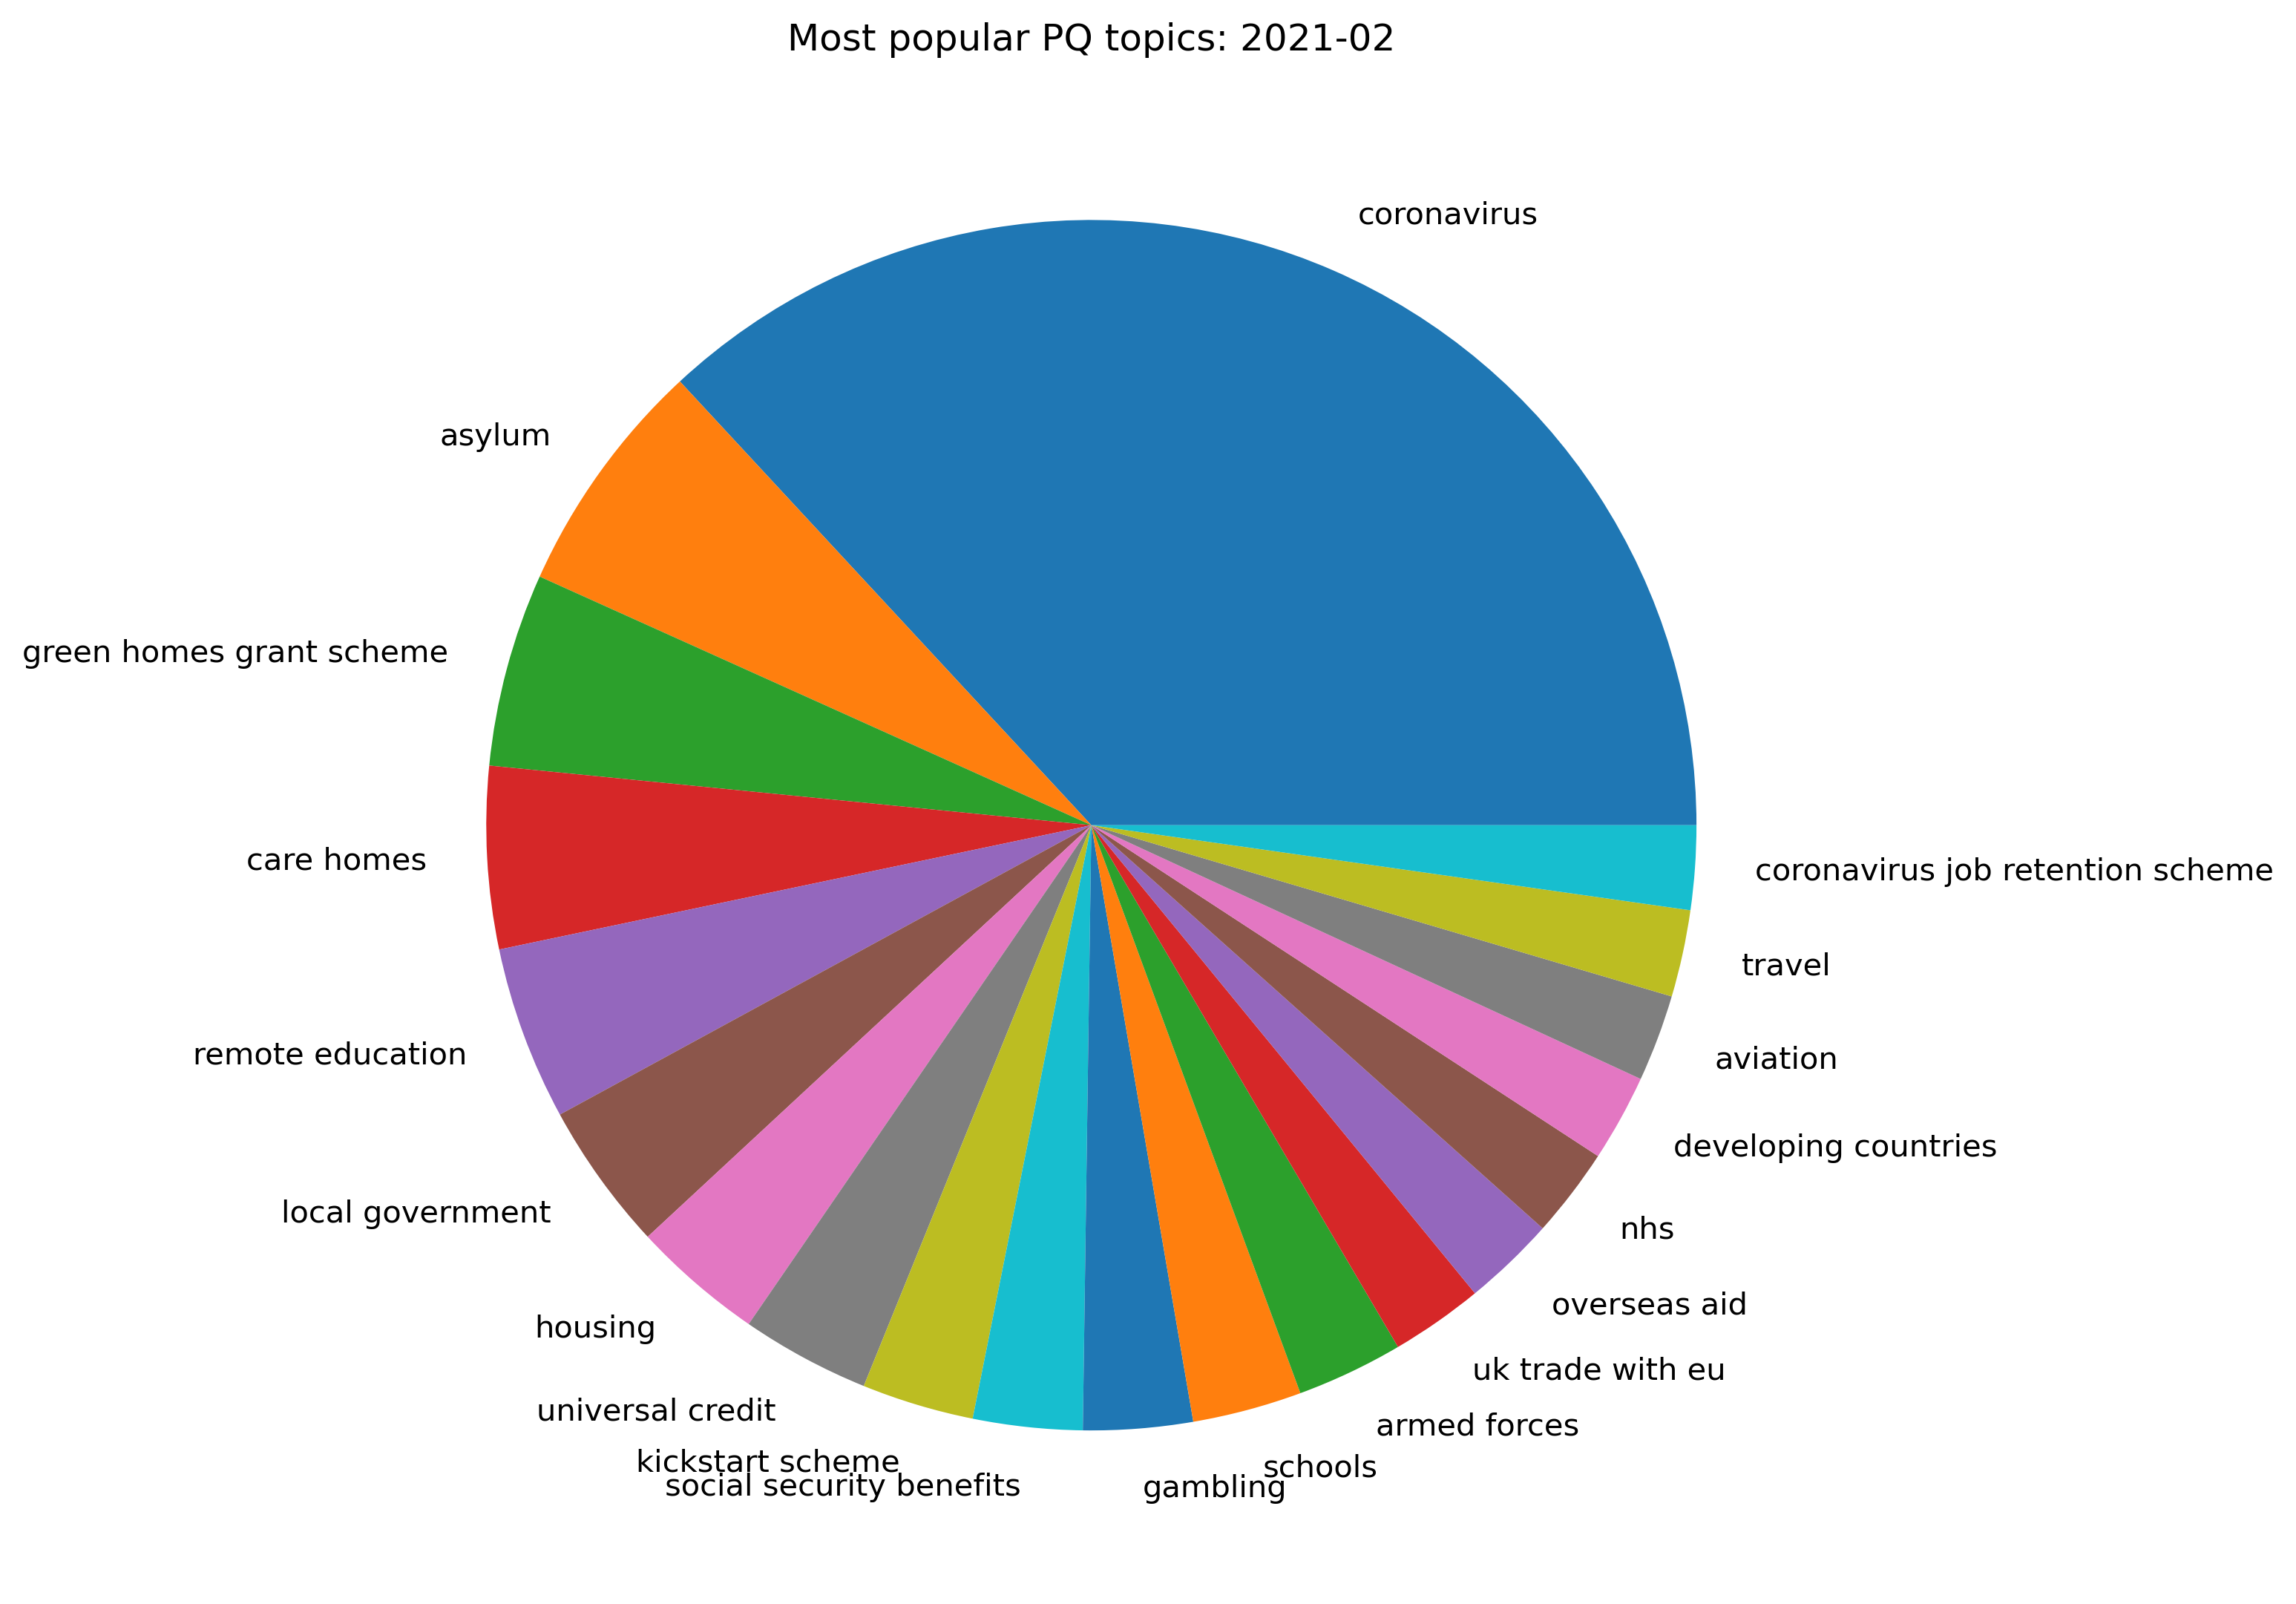

In [13]:
# And the all-time most popular issue is...! 

fig, ax = plt.subplots(figsize=(14, 9), dpi=300)

month = '2021-02'

wpqs[wpqs.year_month == month].topic.value_counts().head(20).plot(kind='pie', ax=ax, legend=False, xticks=[])
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Most popular PQ topics: {m}'.format(m=month))

fig.savefig('pqs_plots/most_popular_{m}'.format(m=month))
plt.show()

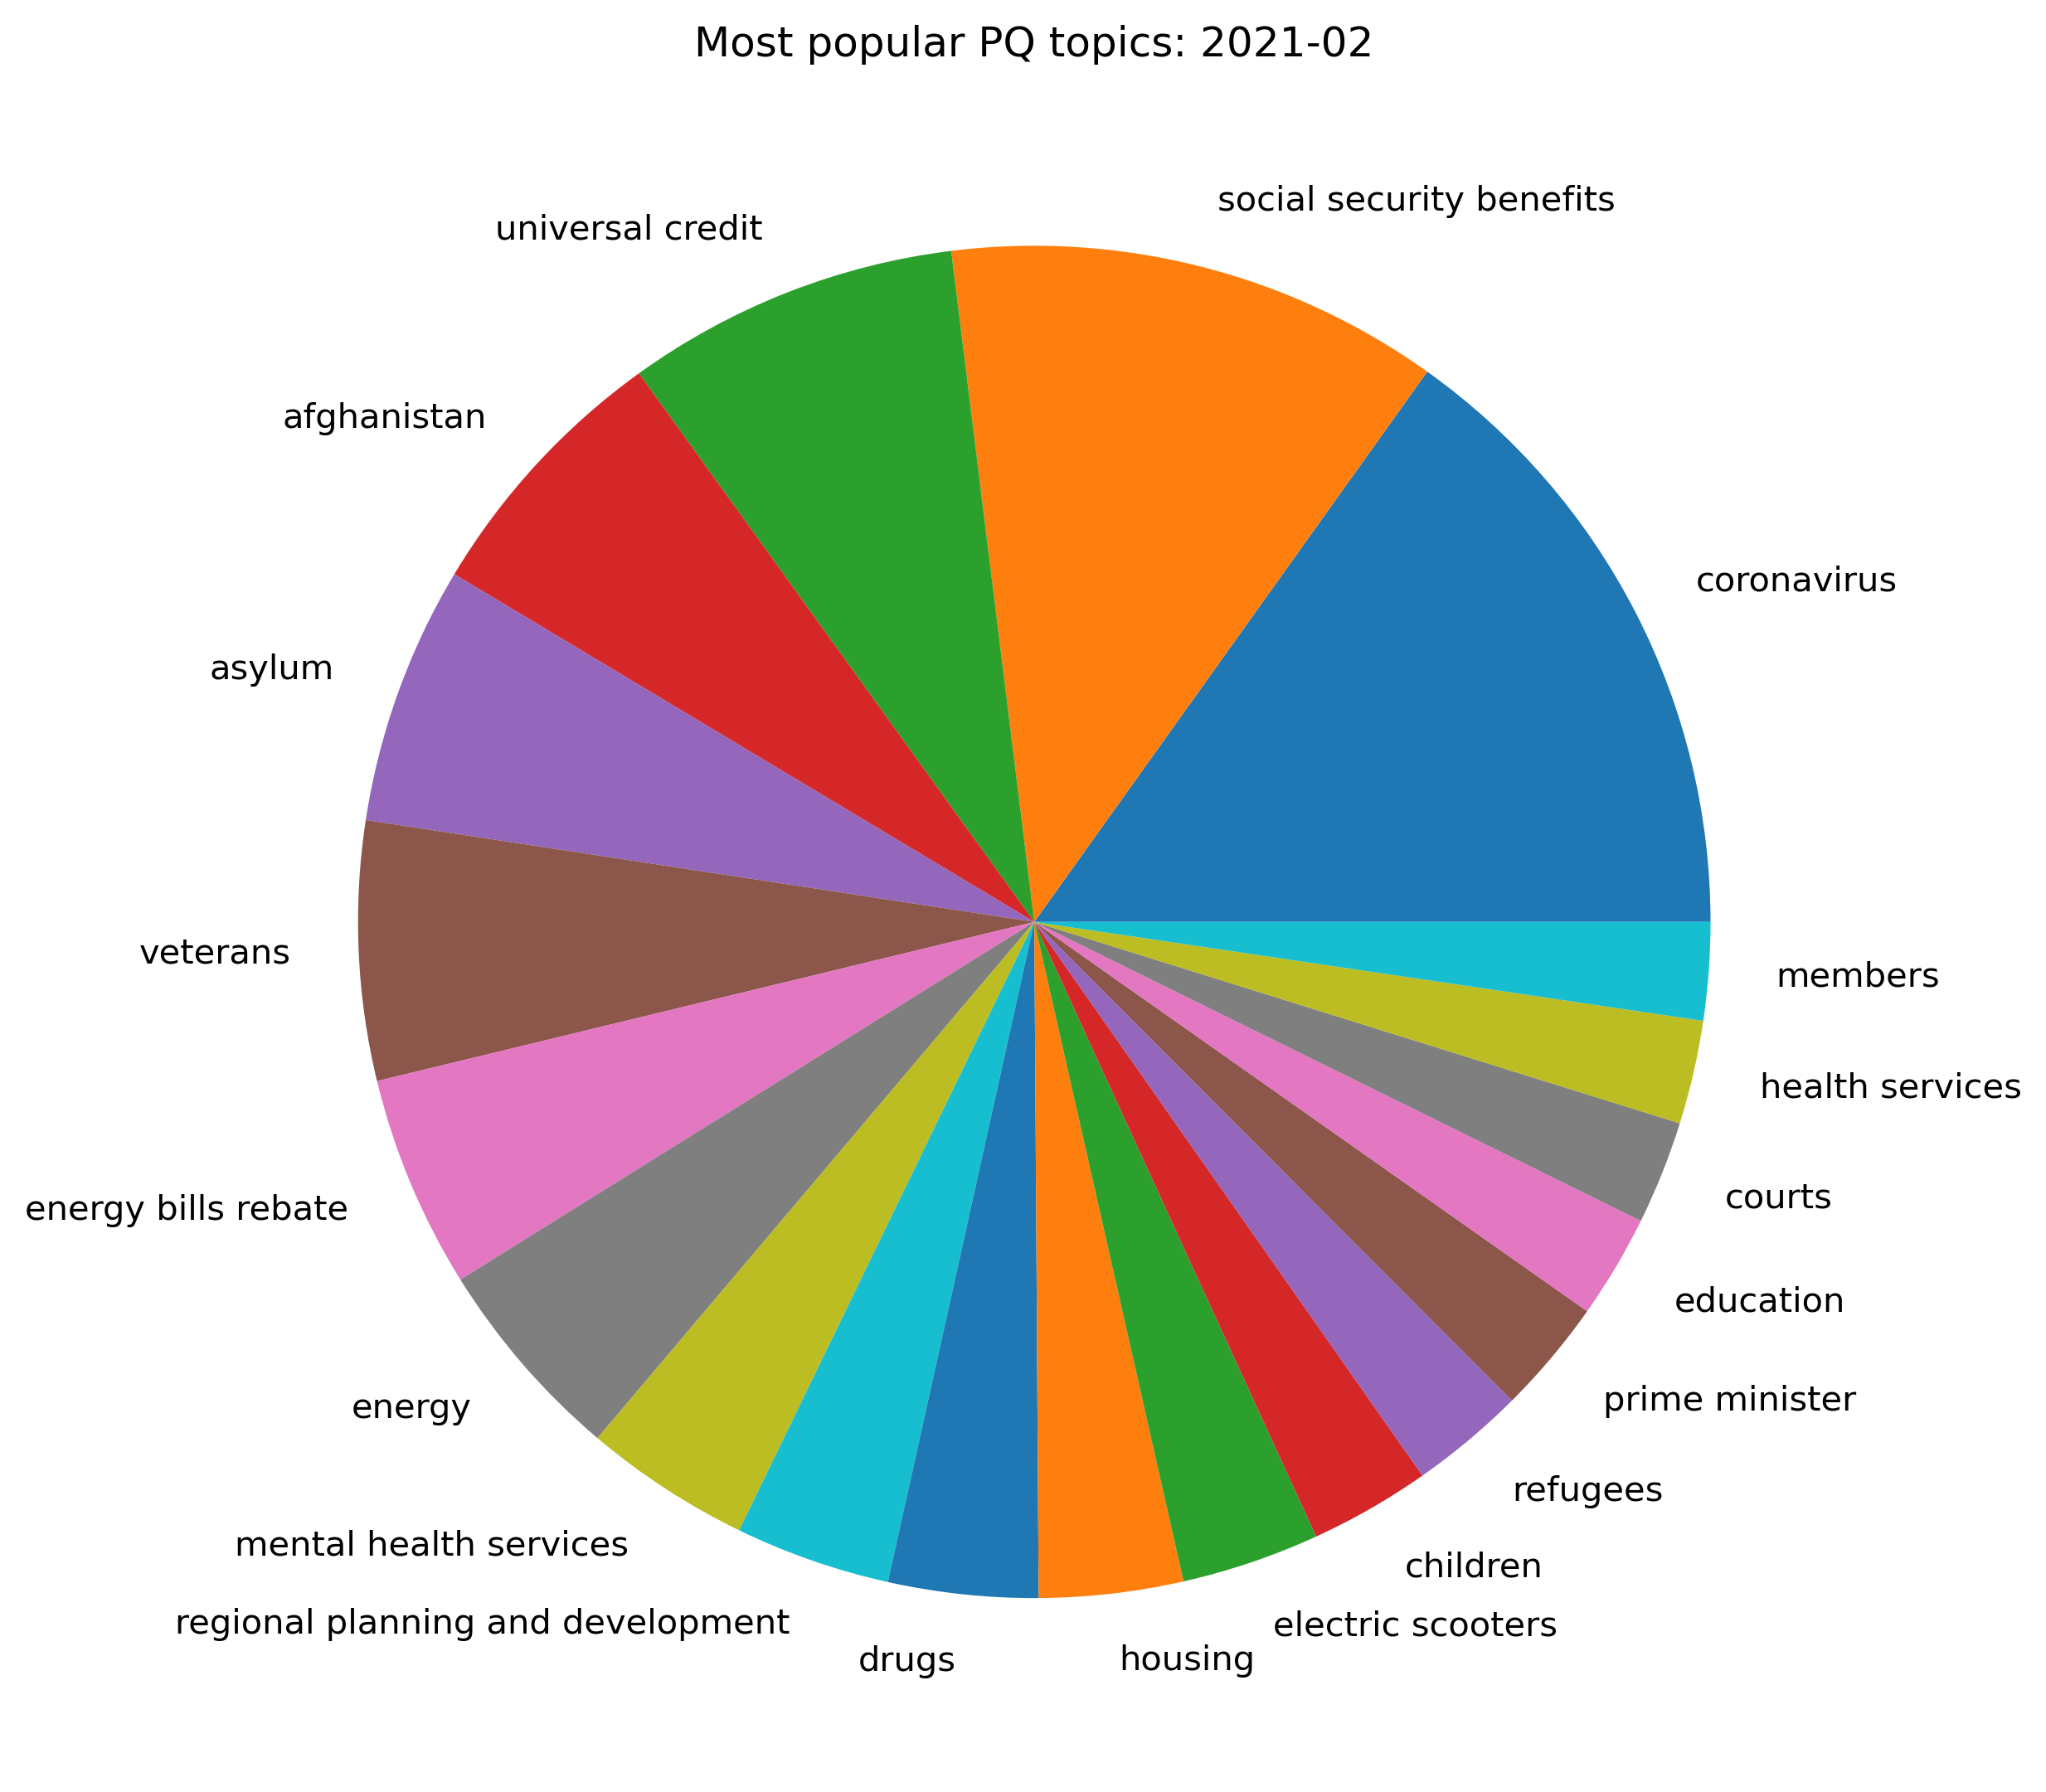

In [14]:
# And the all-time most popular issue is...! 

fig, ax = plt.subplots(figsize=(14, 9), dpi=300)

# month = '2021-02'

wpqs[wpqs.dateAnswered > '2022-02-21'].topic.value_counts().head(20).plot(kind='pie', ax=ax, legend=False, xticks=[])
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Most popular PQ topics: {m}'.format(m=month))

fig.savefig('pqs_plots/most_popular_{m}'.format(m=month))
plt.show()

In [15]:
month = '2022-02'
top = wpqs[wpqs.year_month == month].topic.value_counts(1).head(20) * 100
top_df = top.to_frame()
top_df['topic'] = top_df.topic.round(2)
# print(top_df.to_markdown())

| topic                             | % of PQs |
|:----------------------------------|---------:|
| coronavirus                       | 3.25753  |
| energy                            | 1.81315  |
| asylum                            | 1.5673   |
| social security benefits          | 1.25999  |
| afghanistan                       | 1.01414  |
| mental health services            | 0.952674 |
| driving licences                  | 0.891211 |
| prime minister                    | 0.891211 |
| railways                          | 0.860479 |
| universal credit                  | 0.860479 |
| energy bill discount scheme       | 0.860479 |
| children                          | 0.860479 |
| dental services                   | 0.860479 |
| courts                            | 0.799017 |
| housing                           | 0.768285 |
| schools                           | 0.768285 |
| immigration                       | 0.737554 |
| regional planning and development | 0.737554 |
| business                          | 0.706822 |
| health services                   | 0.706822 |

In [16]:
# Top most popular issues of all time
top = wpqs.topic.value_counts().head(10).index.tolist()

# List of months
months = wpqs.year_month.drop_duplicates().tolist()

# empty list to contain the pandas series objects we'll create
series = []

# Filter out our database so that it only contains topics that are in our list, 'top'
wpqs_sel = wpqs[wpqs.topic.isin(top)]

# Iteratre through the months and get the values
for month in tqdm(months):
    s = wpqs_sel[wpqs_sel.year_month == month].topic.value_counts()
    s.name = month
    series.append(s)
    
    
top_df = pd.DataFrame(series)
top_df = top_df.sort_index()
top_df = top_df.dropna(axis=0, thresh=5)

100%|██████████| 90/90 [00:00<00:00, 1328.49it/s]


In [17]:
# Top most popular issues of all time
top_n = wpqs.topic.value_counts().head(10).index.tolist()

# List of months
months = wpqs.year_month.drop_duplicates().tolist()

series_n = []

wpqs_sel = wpqs[wpqs.topic.isin(top_n)]

for month in tqdm(months):
    s = wpqs_sel[wpqs_sel.year_month == month].topic.value_counts(normalize=True)
    s.name = month
    series_n.append(s)
    
top_df_n = pd.DataFrame(series_n)
top_df_n = top_df_n.sort_index()
top_df_n = top_df_n.dropna(axis=0, thresh=5)

100%|██████████| 90/90 [00:00<00:00, 1236.94it/s]


In [18]:
# Top most popular issues of all time
top_n = wpqs.topic.value_counts().index.tolist()
# top_n = ['brexit']

# List of months
months = wpqs.year_month.drop_duplicates().tolist()

series_n = []

wpqs_sel = wpqs[wpqs.topic.isin(top_n)]

for month in tqdm(months):
    s = wpqs_sel[wpqs_sel.year_month == month].topic.value_counts(normalize=True)
    s.name = month
    series_n.append(s)
    
top_df_n = pd.DataFrame(series_n)
top_df_n = top_df_n.sort_index()
top_df_n = top_df_n.dropna(axis=0, thresh=5)

100%|██████████| 90/90 [00:00<00:00, 450.08it/s]


In [19]:
top_df_n.loc['2022-01'].sort_values()

covid-19 inquiry                        0.000107
crown estate commissioners              0.000107
public statues                          0.000107
glencorse barracks                      0.000107
arctic                                  0.000107
                                          ...   
syria and turkey                             NaN
fraud advisory panel                         NaN
rupert burgess                               NaN
insolvency practitioners association         NaN
convention on biological diversity           NaN
Name: 2022-01, Length: 14438, dtype: float64

In [23]:
top_df_n

,children,personal independence payment,disciplinary proceedings,developing countries,energy,army,equality,railways,general practitioners,universal credit,...,st helens council,iab europe,chocolate and sparkling wines,birmingham city football club,property and roads,syria and turkey,fraud advisory panel,rupert burgess,insolvency practitioners association,convention on biological diversity
2014-06,0.017041,0.012843,0.010126,0.010126,0.009138,0.009138,0.008644,0.008150,0.007903,0.007903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07,0.010496,0.008358,0.000389,0.005248,0.008941,0.001166,NaN,0.011662,0.005831,0.009524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,0.005208,NaN,NaN,0.002604,0.005208,0.005208,NaN,NaN,0.002604,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,0.004614,0.006292,NaN,0.001678,0.012164,0.003356,NaN,0.007970,0.003775,0.003775,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10,0.010710,0.008835,NaN,0.003213,0.005622,0.000535,NaN,0.003748,0.008032,0.007229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10,0.002055,0.001799,NaN,0.007708,0.001799,0.002569,0.000257,0.007451,0.007194,0.009250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11,0.005618,0.002148,NaN,0.003305,0.001818,0.001487,0.000330,0.011897,0.006775,0.006114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12,0.005234,0.000683,NaN,0.001821,0.002503,0.006145,0.000228,0.011379,0.005234,0.006145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01,0.003431,0.001286,NaN,0.002251,0.005575,0.000322,0.000536,0.007826,0.003323,0.001822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


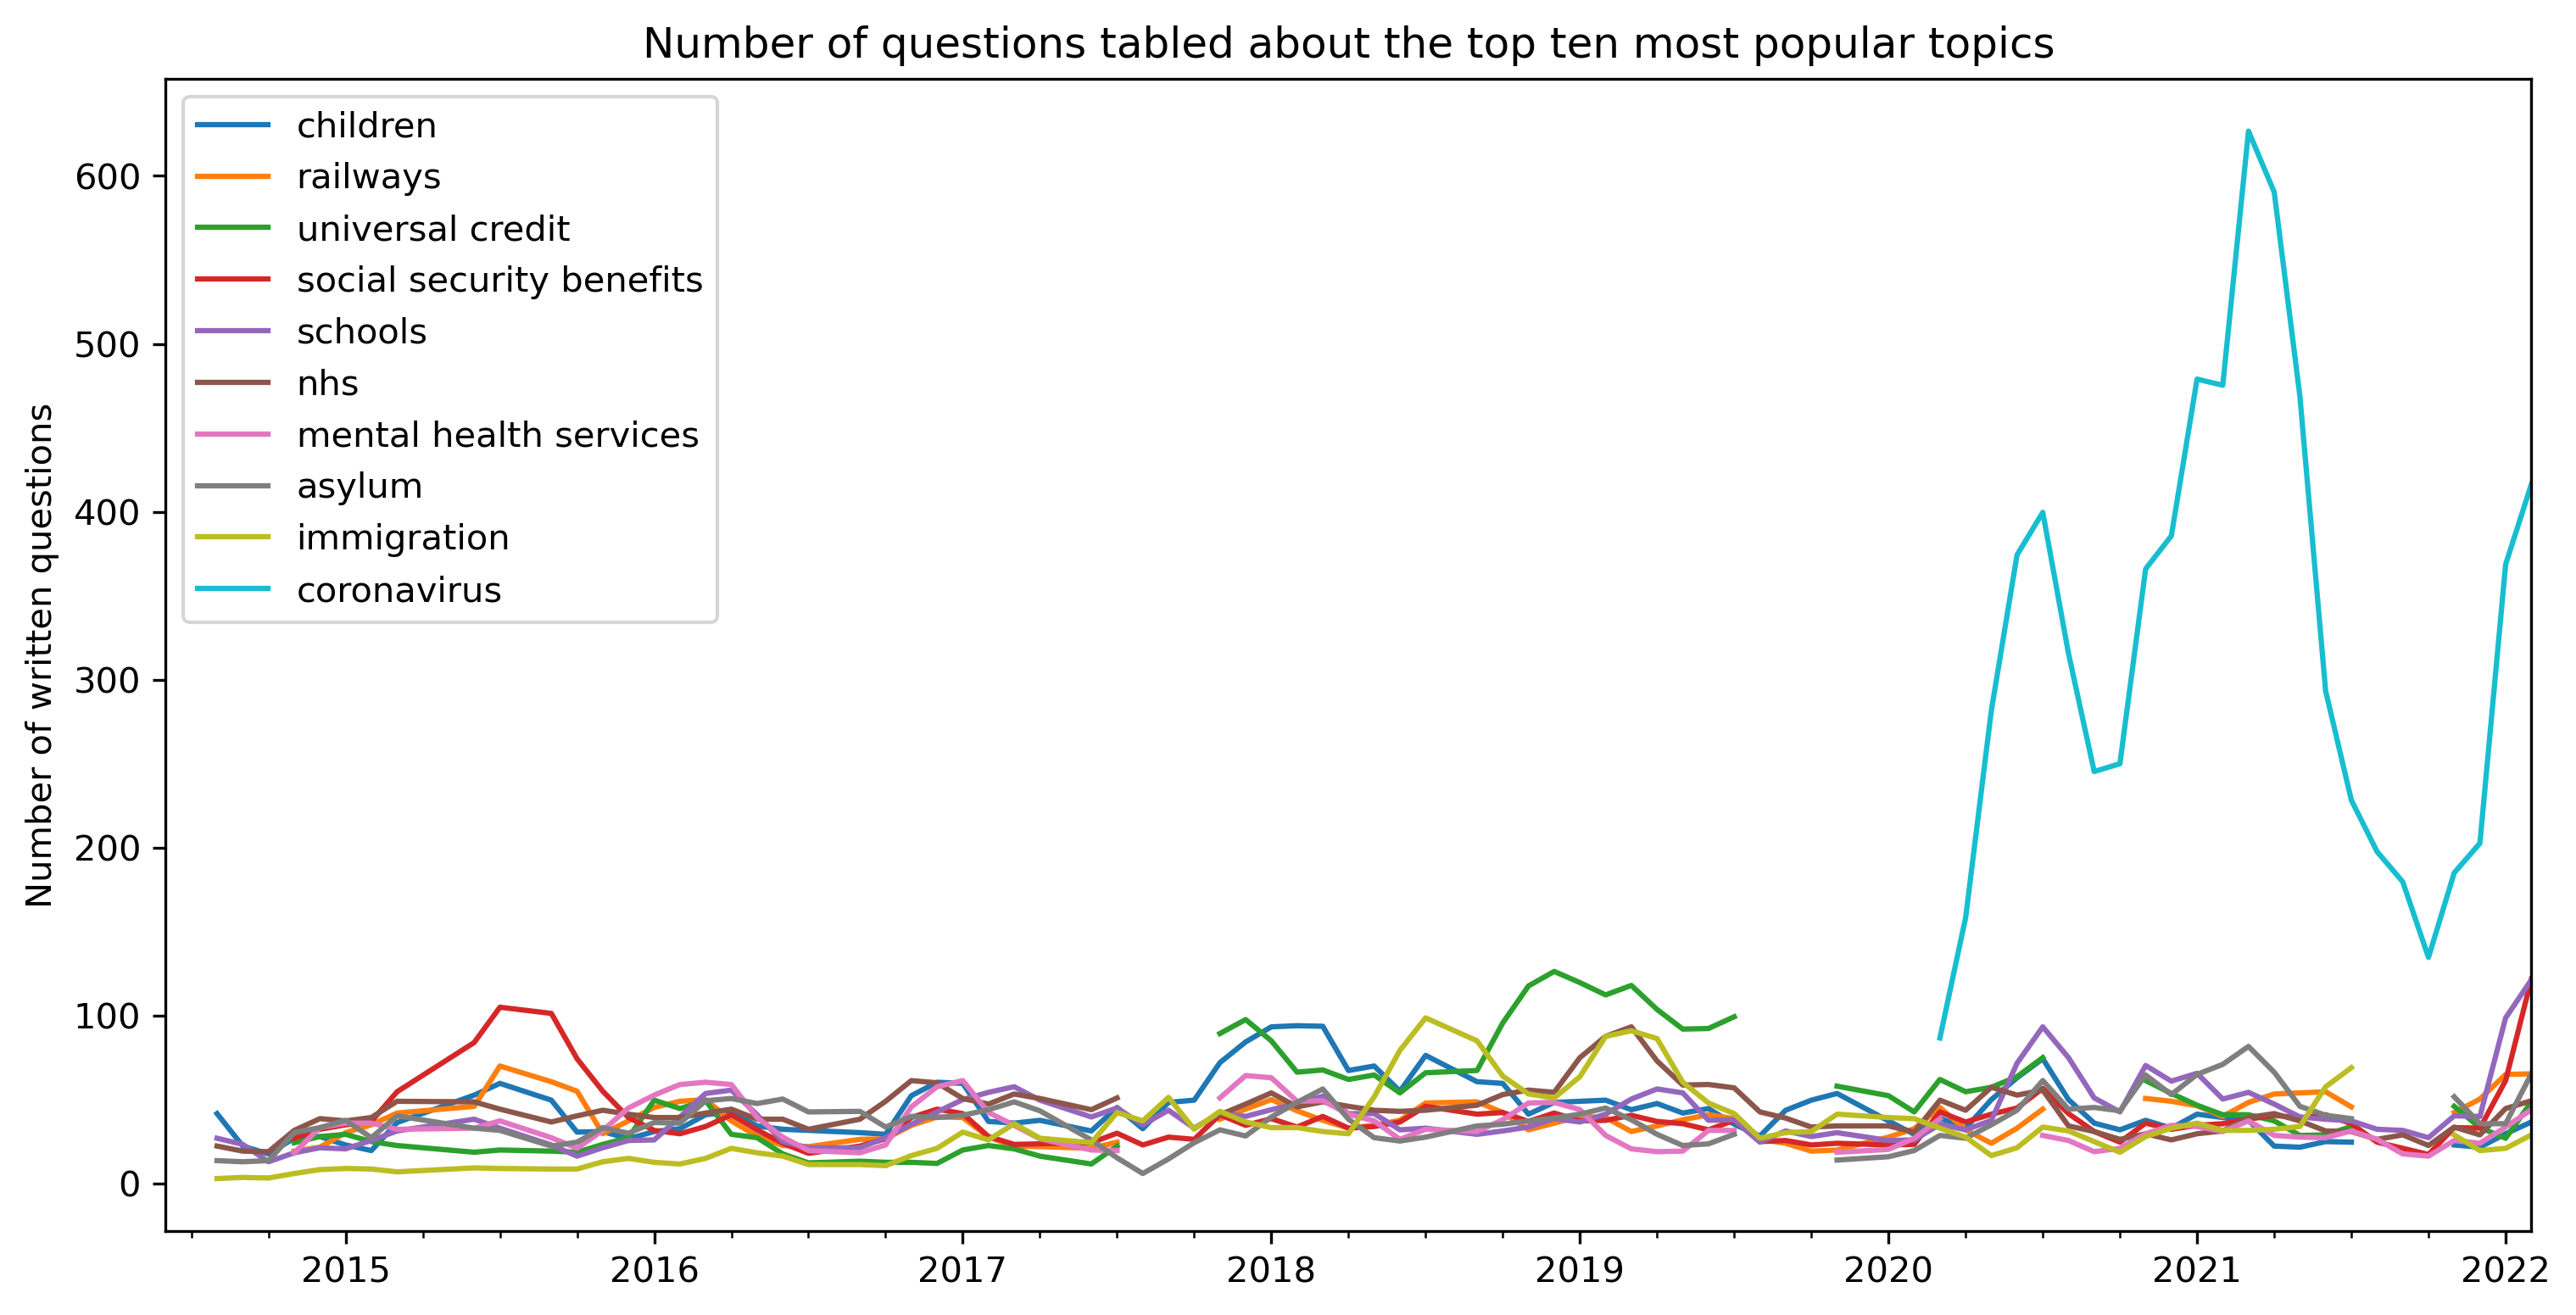

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)

ax1.set_title('Number of questions tabled about the top ten most popular topics')
ax1.set_ylabel('Number of written questions')
top_df.rolling(3).mean().plot(ax=ax1)

fig.savefig('pqs_plots/top_10_pqs_vol.png')
plt.show()

KeyboardInterrupt: 

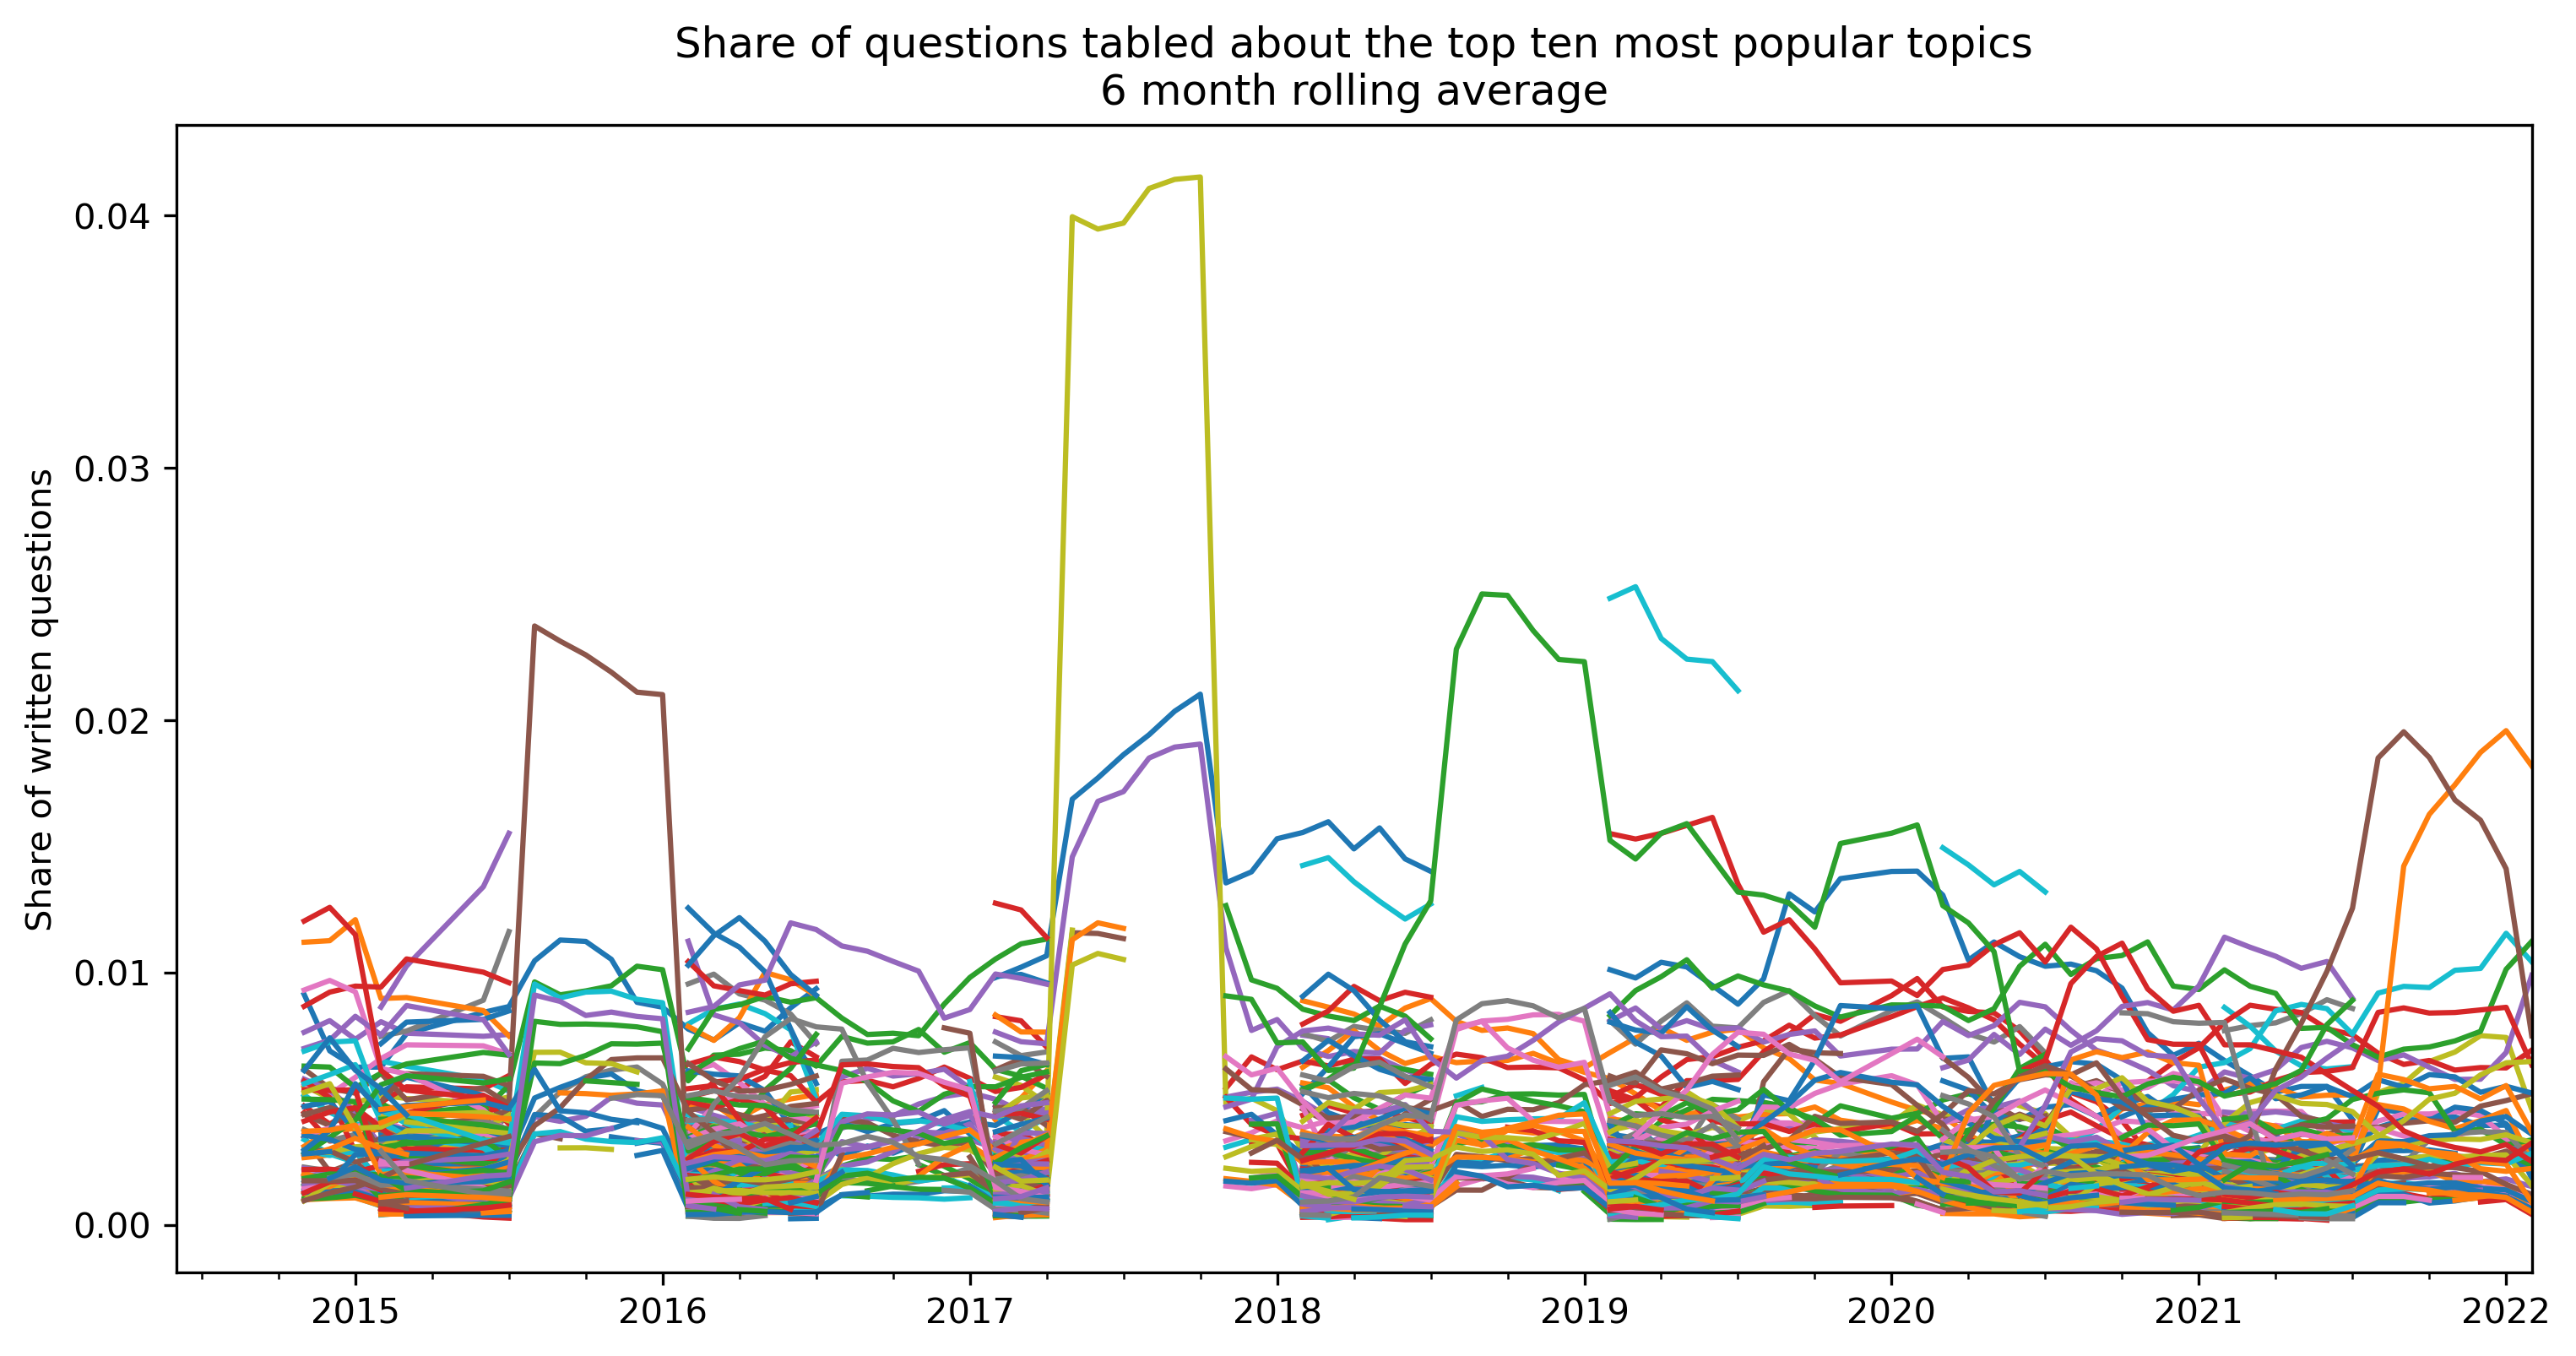

In [22]:
fig, ax2 = plt.subplots(figsize=(12, 6), dpi=300)

ax2.set_title('Share of questions tabled about the top ten most popular topics\n6 month rolling average')
ax2.set_ylabel('Share of written questions')
top_df_n.rolling(6).mean().plot(ax=ax2)

plt.show()

In [39]:
# Monthly most popular issues
wpqs_monthly = wpqs.copy()
wpqs_monthly = wpqs_monthly[['year_month', 'topic', 'askingMemberId']]
wpqs_monthly = wpqs_monthly[wpqs_monthly.topic.str.contains('russia')]

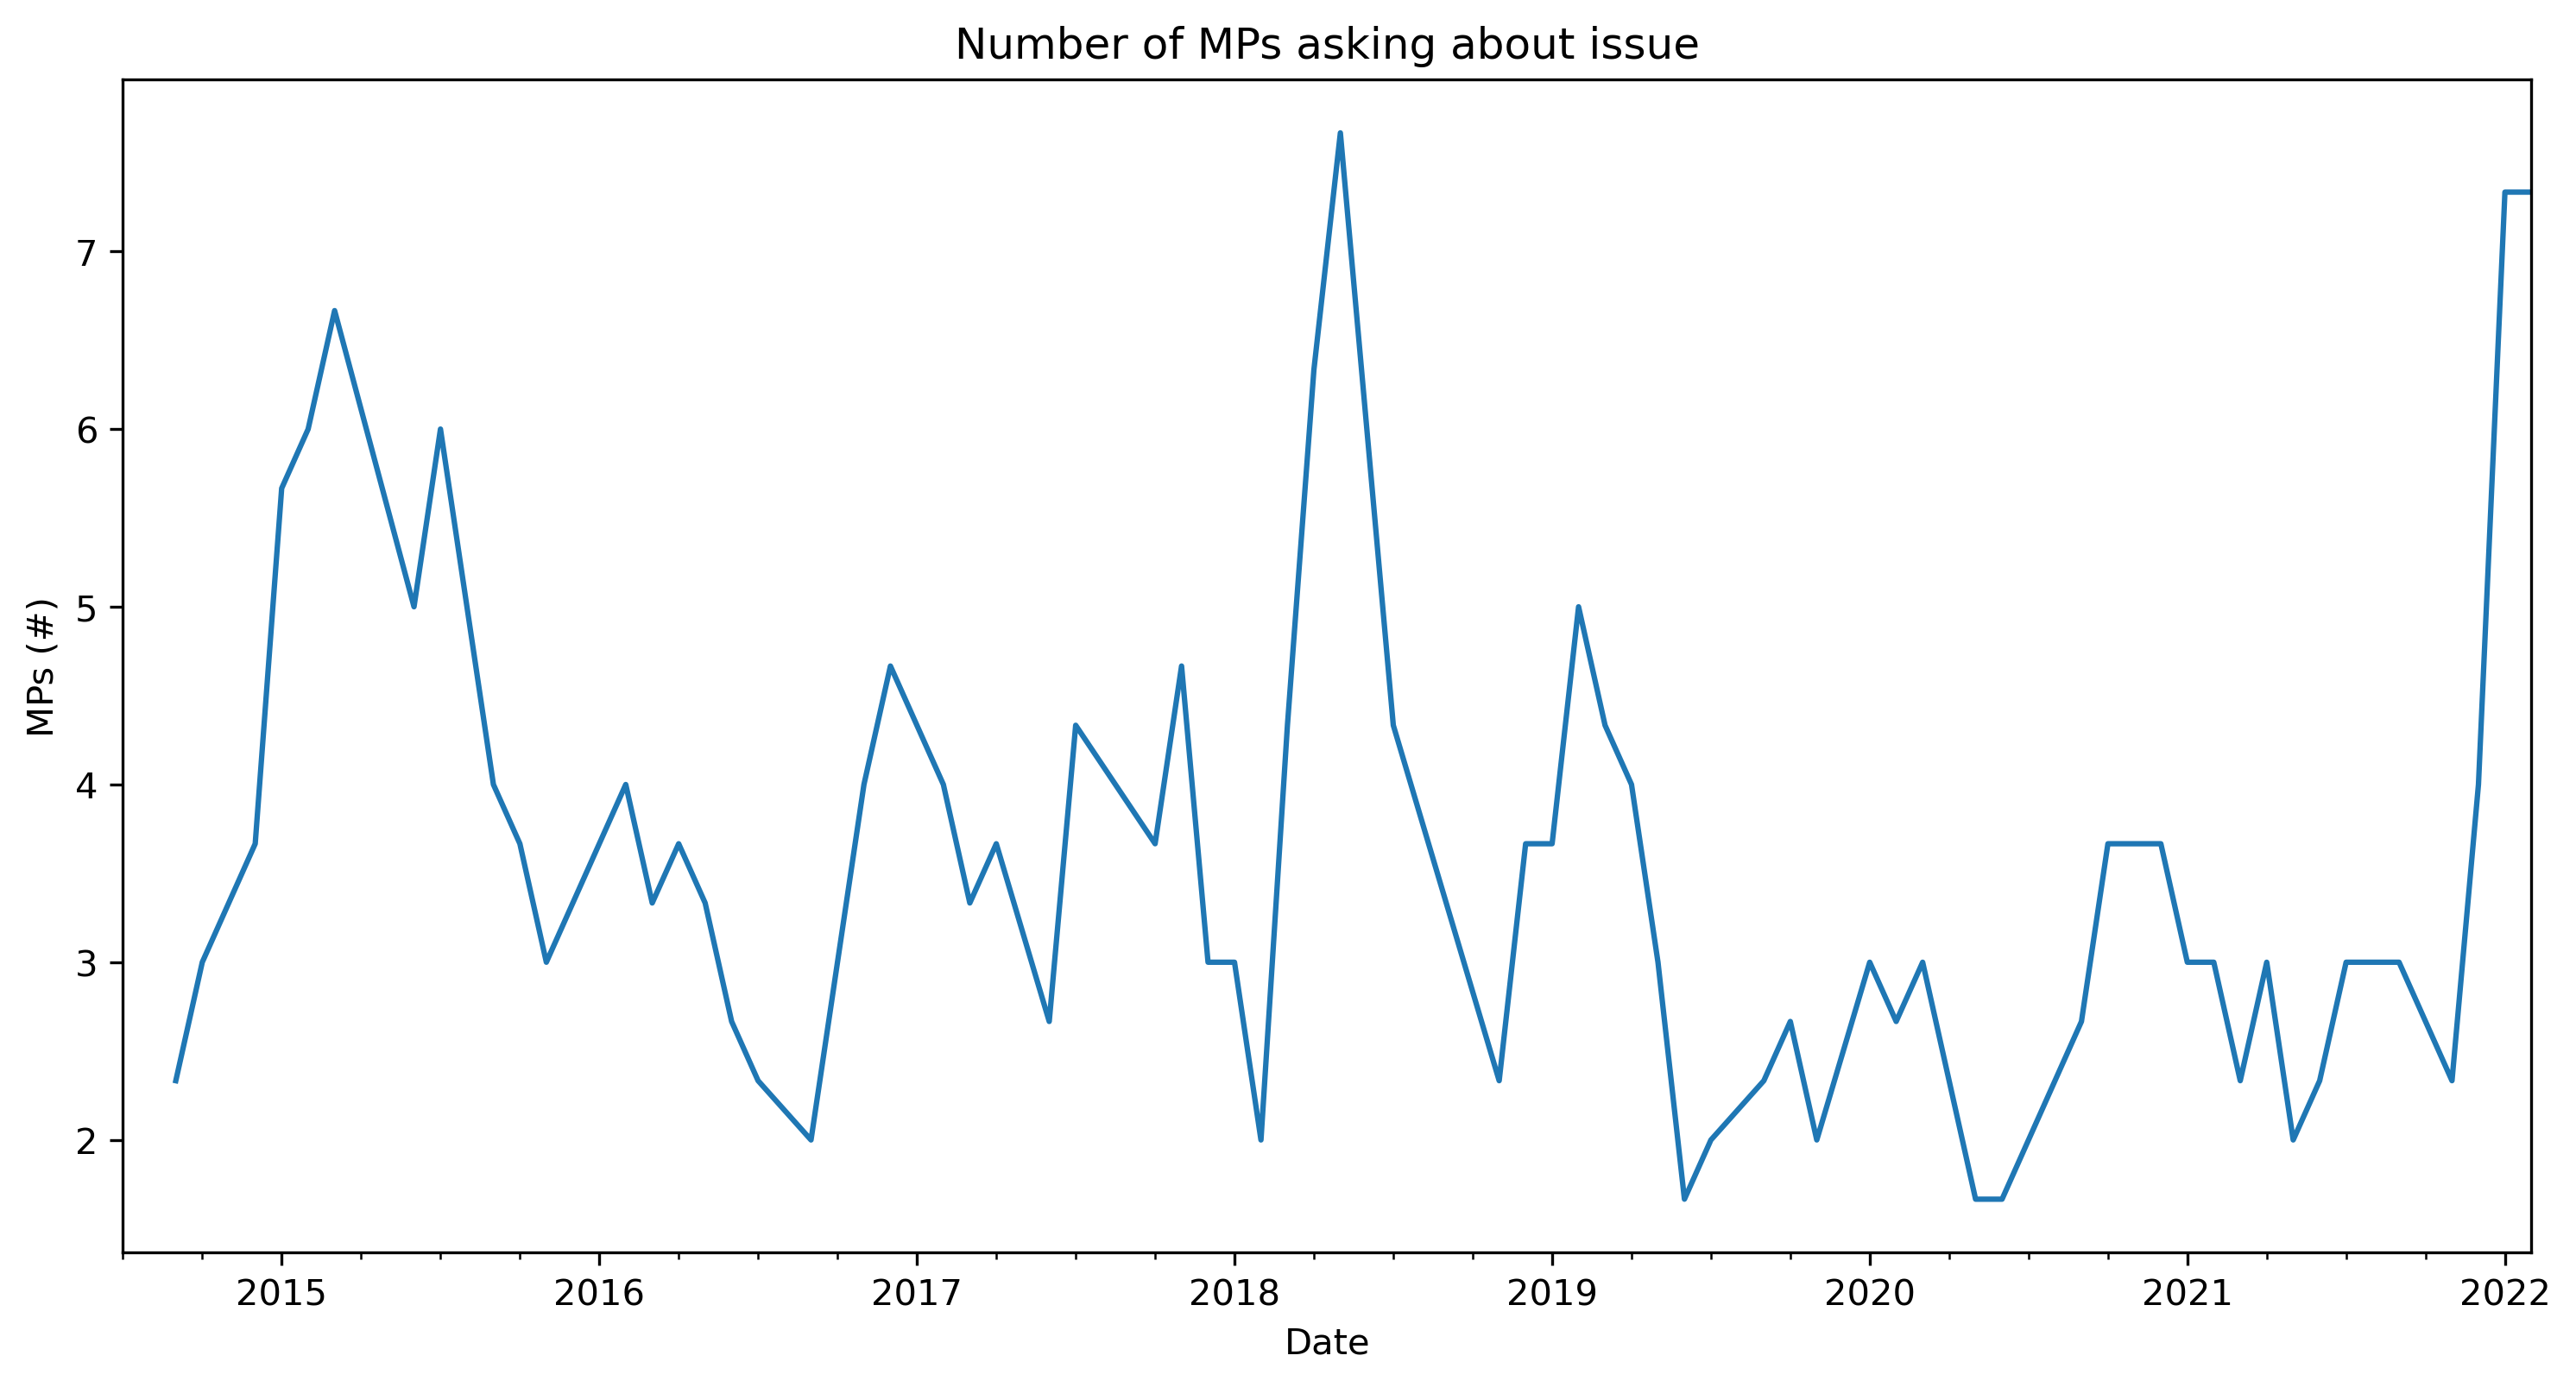

In [40]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.set_title('Number of MPs asking about issue')
ax.set_ylabel('MPs (#)')

wpqs_monthly.groupby(['year_month']).nunique().askingMemberId.rolling(3).mean().plot(ax=ax)
ax.set_xlabel('Date')

# fig.savefig('pqs_plots/total_pqs_monthly.png')

plt.show()

In [83]:
# We need to iterate through the issues and then go from there
wpqs_monthly_i = wpqs.copy()
wpqs_monthly_i = wpqs_monthly_i[['year_month', 'topic', 'askingMemberId']]

# Transform the dataset, counting the number of unique MP ids associated with any topic, giving us a dataset
wpqs_monthly_i = wpqs_monthly_i.groupby(['year_month', 'topic']).nunique().reset_index()

<AxesSubplot:>

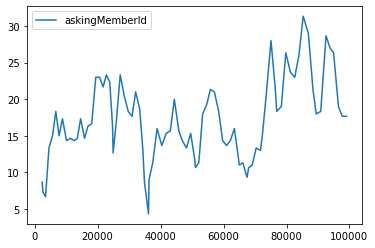

In [84]:

keyword = 'asylum'
wpqs_monthly_i[wpqs_monthly_i.topic == keyword].rolling(3).mean().plot()

In [91]:
mps_pqs = wpqs_monthly_i.sort_values(['year_month', 'askingMemberId']).set_index('year_month')

In [135]:
mps_pqs[mps_pqs.index == '2022-02'].sort_values('askingMemberId').head(3)

,topic,askingMemberId
year_month,,
2022-02,3g,1
2022-02,ophthalmic services,1
2022-02,opioids,1


In [142]:
lst_tops = []

for m in mps_pqs.index.unique().tolist():
    lst_tops.append(mps_pqs[mps_pqs.index == m].sort_values('askingMemberId', ascending=False).head(3))
    
top_3_monthly = pd.concat(lst_tops)

In [145]:
top_3_monthly.topic.value_counts()

nhs                                 40
schools                             30
coronavirus                         24
universal credit                    22
children                            20
social security benefits            17
immigration                         14
refugees                             8
railways                             8
asylum                               7
travel                               6
brexit                               5
coronavirus job retention scheme     4
developing countries                 4
syria                                4
armed forces                         4
                                     4
housing                              3
care homes                           3
personal independence payment        3
energy                               3
uk membership of eu                  3
home office                          2
afghanistan                          2
iran                                 2
ministry of defence      

In [118]:
mps_pqs.askingMemberId.index

PeriodIndex(['2014-06', '2014-06', '2014-06', '2014-06', '2014-06', '2014-06',
             '2014-06', '2014-06', '2014-06', '2014-06',
             ...
             '2022-02', '2022-02', '2022-02', '2022-02', '2022-02', '2022-02',
             '2022-02', '2022-02', '2022-02', '2022-02'],
            dtype='period[M]', name='year_month', length=100283, freq='M')

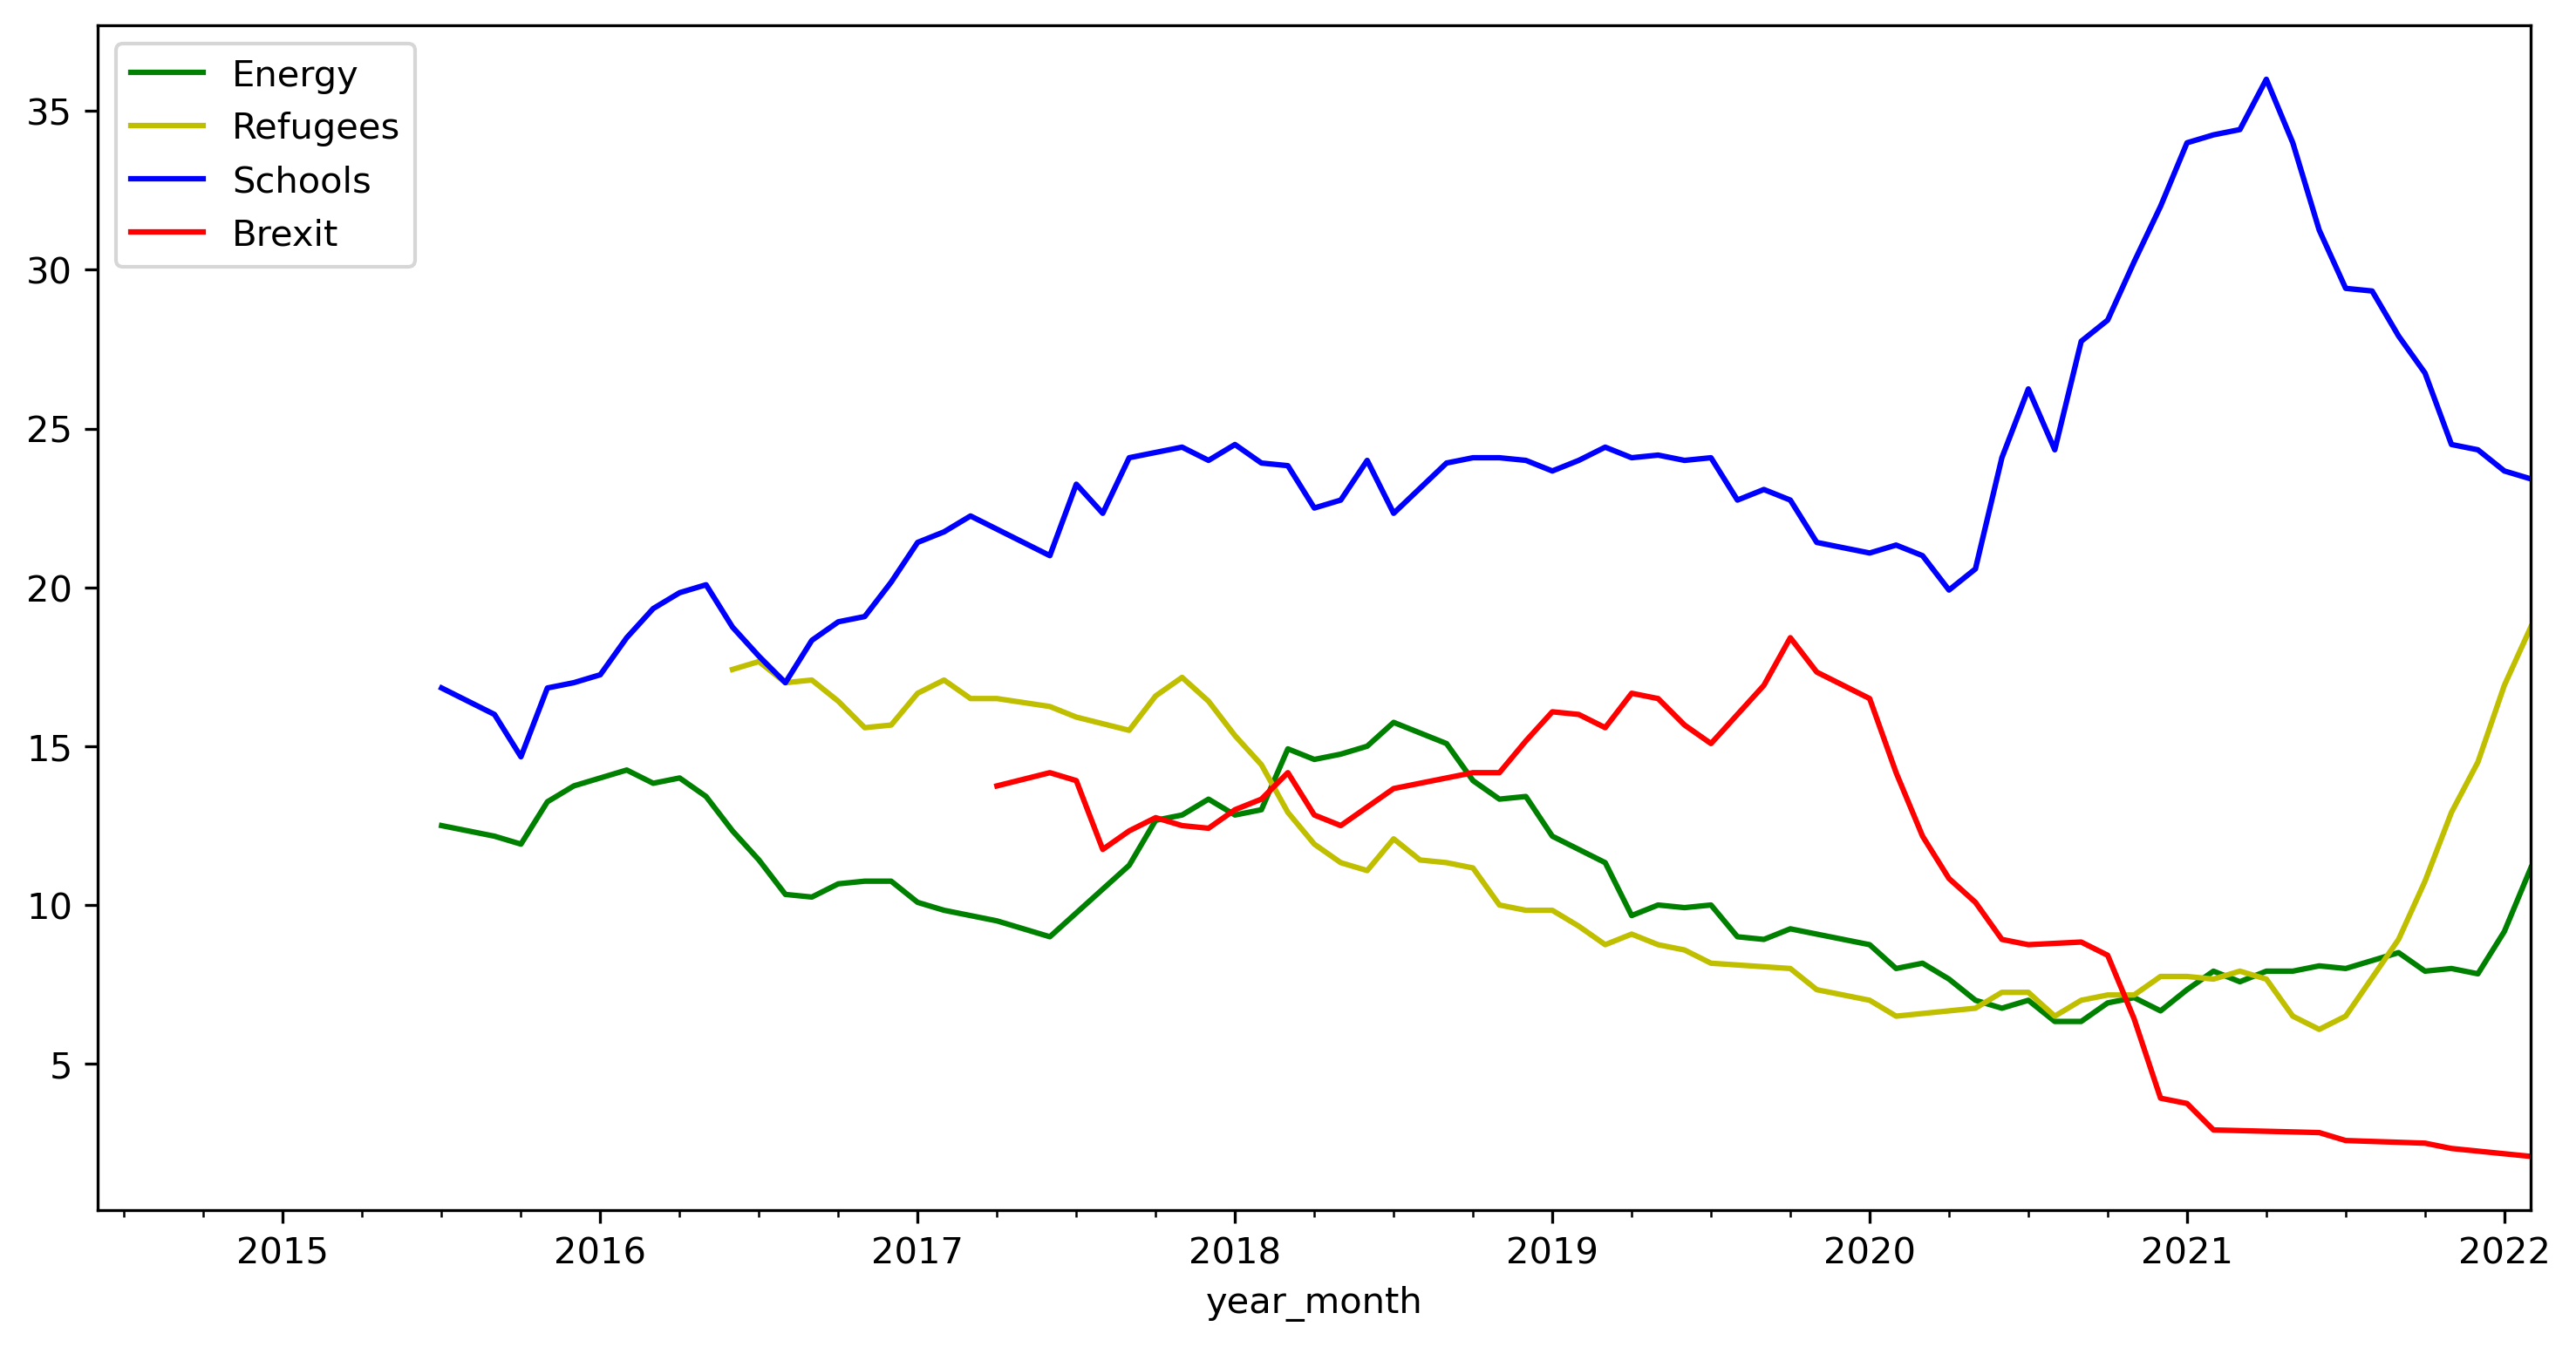

In [155]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

rolling = 12

# mps_pqs[mps_pqs.topic == 'coronavirus'].askingMemberId.plot(ax=ax)
mps_pqs[mps_pqs.topic == 'energy'].askingMemberId.rolling(rolling).mean().plot(ax=ax, c='g', label='Energy')
mps_pqs[mps_pqs.topic == 'refugees'].askingMemberId.rolling(rolling).mean().plot(ax=ax, c='y', label='Refugees')
# mps_pqs[mps_pqs.topic == 'nhs'].askingMemberId.rolling(rolling).mean().plot(ax=ax, c='r', label='NHS')
mps_pqs[mps_pqs.topic == 'schools'].askingMemberId.rolling(rolling).mean().plot(ax=ax, c='b', label='Schools')
mps_pqs[mps_pqs.topic == 'brexit'].askingMemberId.rolling(rolling).mean().plot(ax=ax, c='r', label='Brexit')



ax.legend()
plt.show()

### Monthly total WPQs tabled by each party's MPs

In [268]:
# Weekly total PQs with a particular keyword. 
wpqs_mt = wpqs.copy()
wpqs_mt = wpqs_mt
wpqs_mt['topic'] = wpqs_mt.topic.fillna('')
# wpqs_mt = wpqs_mt[wpqs_mt.topic == 'ukraine']
# wpqs_mt = wpqs_mt[wpqs_mt.questionText.str.contains('charge point')]


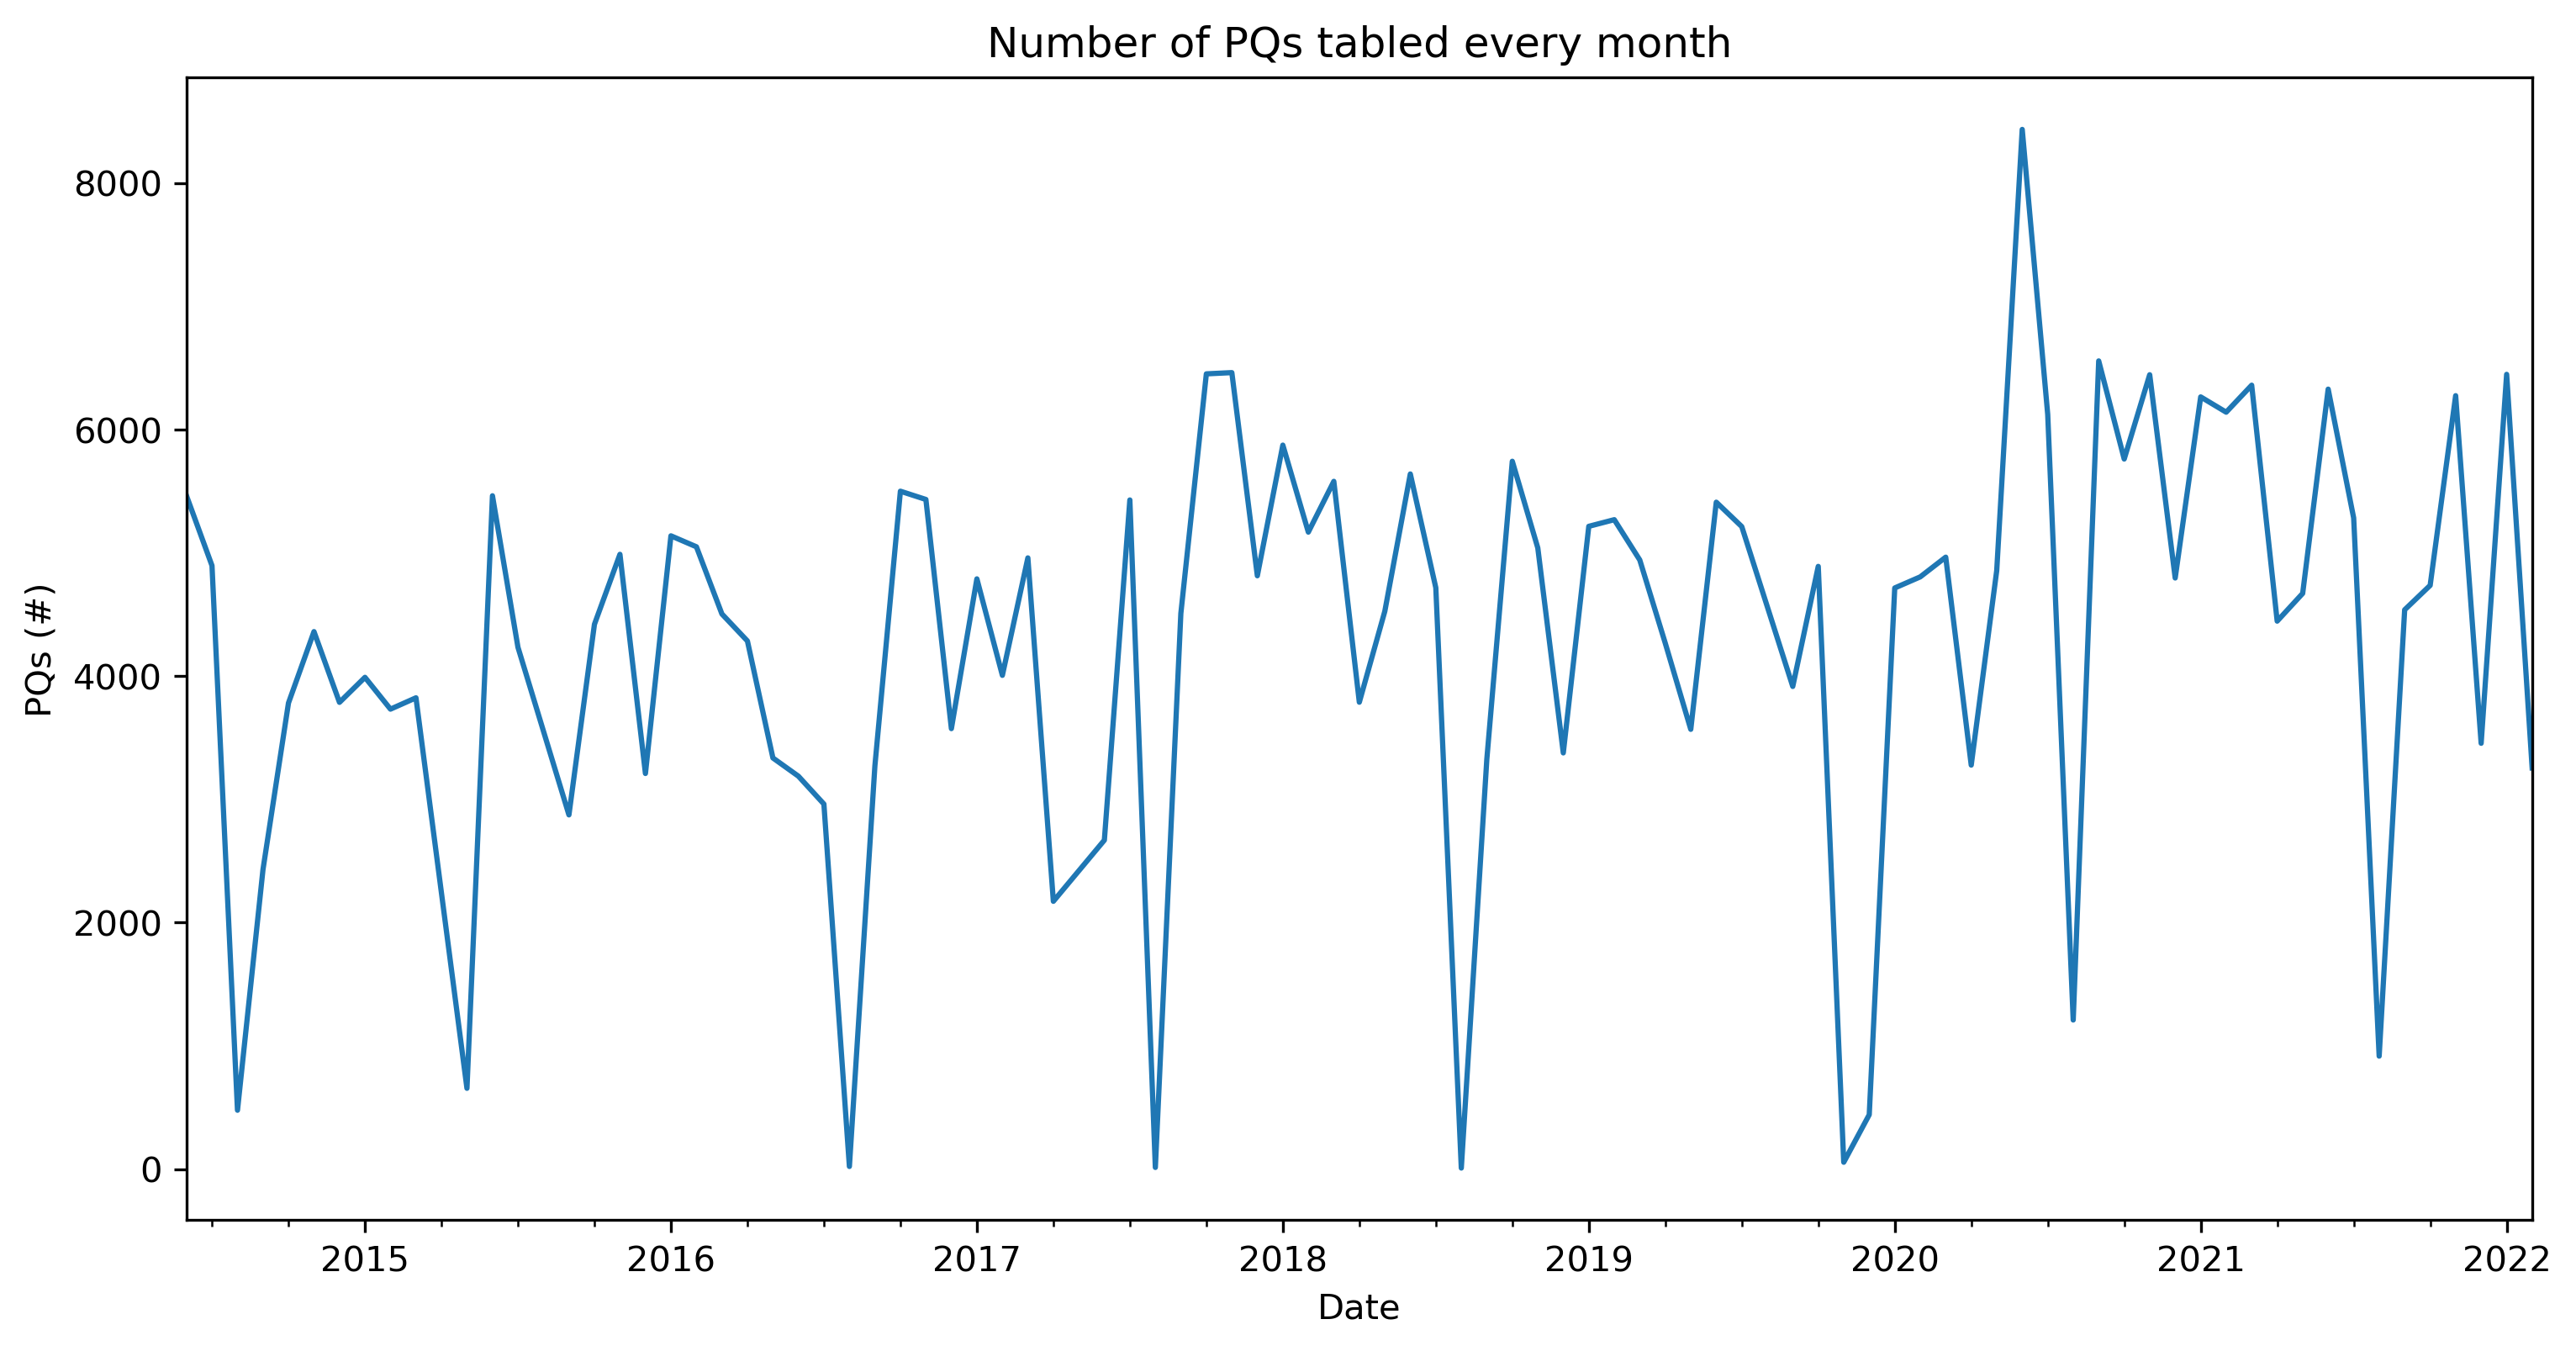

In [292]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

ax.set_title('Number of PQs tabled every month')
ax.set_ylabel('PQs (#)')

wpqs_mt.groupby(['year_month']).count().id.rolling(1).mean().plot(ax=ax)
ax.set_xlabel('Date')

fig.savefig('pqs_plots/total_pqs_monthly.png')

plt.show()

In [64]:
wpqs_mt = wpqs_mt.set_index('dateAnswered')[['latestPartyabbreviation']]
wpqs_mt['count'] = 1

In [65]:
wpqs_mt = wpqs_mt.groupby(['dateAnswered', 'latestPartyabbreviation']).sum().reset_index('latestPartyabbreviation').pivot(columns='latestPartyabbreviation', values='count').resample('W').sum()

In [66]:
wpqs_mt.head()

latestPartyabbreviation,Alba,Con,DUP,Ind,LD,Lab,SDLP,SNP,UUP
dateAnswered,,,,,,,,,
2014-06-08,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2014-06-15,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2014-06-22,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-29,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2014-07-06,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


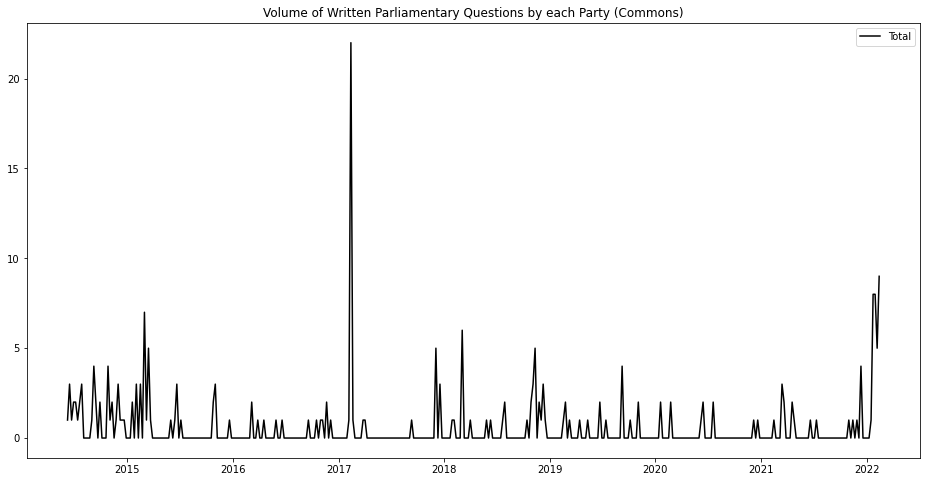

In [67]:
fig, ax = plt.subplots(figsize=(16, 8))

rp = 1

# ax.plot(wpqs_mt.rolling(rp).mean().Lab, c='r', label='Labour')
# ax.plot(wpqs_mt.rolling(rp).mean().Con, c='b', label='Conservative')
# ax.plot(wpqs_mt.rolling(rp).mean().SNP, c='y', label='SNP')
# ax.plot(wpqs_mt.rolling(rp).mean().LD, c='gold', label='Lib Dem')
ax.plot(wpqs_mt.rolling(rp).mean().sum(axis=1), c='black', label='Total')
# ax.plot(wpqs_mt.rolling(rp).mean().Green, c='g', label='Green')

ax.set_title('Volume of Written Parliamentary Questions by each Party (Commons)')

ax.legend()

# wpqs_mt.plot(ax=ax)

#### Number of MPs asking about a particular issue in a month

Volume of questions could be misleading, since MPs may table several questions to several different departments about one issue, and only one PQ to another department about another issue, yet care about both issues equally. Volume of questions is therefore an inaccurate measure of an issue's level of interest. 

This **will be** a script to examine the numbers of MPs asking about any particular issue in a given month. 

In [16]:
wpqs_mp_num = wpqs.copy()
wpqs_mp_num = wpqs_mp_num[wpqs_mp_num.house == 'Commons']
wpqs_mp_num['heading'] = wpqs_mp_num.heading.fillna('')
wpqs_mp_num['issue'] = ''
wpqs_mp_num['issue'] = wpqs_mp_num.progress_apply(lambda row: 'russia' if ('russia' or 'ukraine') in row['questionText'] else row['issue'], axis=1)
wpqs_mp_num['issue'] = wpqs_mp_num.progress_apply(lambda row: 'evs' if ('electric vehicle' or 'electric car' or 'charge point') in row['questionText'] else row['issue'], axis=1)

100%|██████████| 321151/321151 [00:03<00:00, 99090.34it/s] 


In [17]:
wpqs_mp_num = wpqs_mp_num.groupby(['dateAnswered', 'askingMemberId', 'issue']).count()[['id']].reset_index(['askingMemberId', 'issue'])

In [18]:
wpqs_mp_num['number_mps'] = 1

In [19]:
wpqs_mp_num = wpqs_mp_num.groupby(['dateAnswered', 'issue']).sum()

In [20]:
wpqs_mp_num.reset_index(inplace=True)

In [21]:
wpqs_mp_num.head()

,dateAnswered,issue,askingMemberId,id,number_mps
0,2014-06-04,,293147,652,133
1,2014-06-05,,156585,302,70
2,2014-06-06,,37857,98,18
3,2014-06-09,,149952,272,74
4,2014-06-09,russia,237,1,1


In [22]:
wpqs_mp_num.issue.value_counts()

          1381
russia     388
evs        230
Name: issue, dtype: int64

In [23]:
wpqs_mp_num['month'] = wpqs_mp_num['dateAnswered'].dt.to_period('M')

# pd.to_datetime(df['birth_date']).dt.to_period('M')

In [24]:
wpqs_mp_num = wpqs_mp_num.groupby(['month', 'issue']).sum()[['id', 'number_mps']].reset_index('issue')

In [25]:
# Most consistently PQ'ed issues:
wpqs_mp_num.issue.value_counts()


          89
russia    82
evs       62
Name: issue, dtype: int64

<AxesSubplot:xlabel='month'>

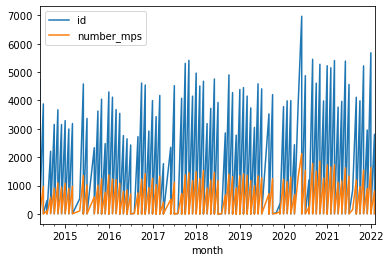

In [29]:
wpqs_mp_num.plot()

In [34]:
wpqs[(wpqs.answeringBodyName == 'Department for Transport') & (wpqs.dateAnswered > '2022-02-01')].heading.value_counts()

driving licences: applications            13
electric vehicles: charging points         9
driving licences: medical examinations     9
bus services: finance                      7
electric scooters: hire services           6
                                          ..
taxis: assistance animals                  1
motor vehicles: noise                      1
motorways: safety                          1
low emission zones: greater london         1
railways: greater london                   1
Name: heading, Length: 125, dtype: int64

In [35]:
wpqs[(wpqs.latestPartyabbreviation=='Lab') & (wpqs.dateAnswered > '2022-02-01')].answeringBodyName.value_counts()

Department of Health and Social Care                       306
Treasury                                                   160
Foreign, Commonwealth and Development Office               126
Department for Work and Pensions                           114
Department for Education                                   111
Home Office                                                104
Department for Transport                                   101
Department for Business, Energy and Industrial Strategy    100
Department for Levelling Up, Housing and Communities        84
Ministry of Justice                                         77
Ministry of Defence                                         67
Cabinet Office                                              67
Department for Environment, Food and Rural Affairs          45
Department for Digital, Culture, Media and Sport            45
Department for International Trade                          26
Attorney General                                       

In [36]:
wpqs[(wpqs.latestPartyabbreviation=='Con') & (wpqs.dateAnswered > '2022-02-01')].answeringBodyName.value_counts()

Department of Health and Social Care                       128
Treasury                                                    51
Department for Transport                                    50
Foreign, Commonwealth and Development Office                41
Department for Environment, Food and Rural Affairs          39
Department for Business, Energy and Industrial Strategy     39
Department for Education                                    33
Department for Digital, Culture, Media and Sport            32
Ministry of Justice                                         28
Ministry of Defence                                         28
Home Office                                                 25
Department for Levelling Up, Housing and Communities        23
Cabinet Office                                              21
Department for Work and Pensions                            18
Women and Equalities                                         5
Leader of the House                                    

In [40]:
wpqs_party_dept = wpqs.groupby(['dateAnswered', 'answeringBodyName', 'latestPartyabbreviation']).count()[['id']].reset_index(['answeringBodyName', 'latestPartyabbreviation'])

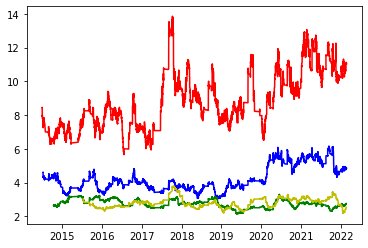

In [41]:
fig, ax = plt.subplots()

ax.plot(wpqs_party_dept[wpqs_party_dept.latestPartyabbreviation == 'Lab'].id.rolling(window=365).mean(), c='r')
ax.plot(wpqs_party_dept[wpqs_party_dept.latestPartyabbreviation == 'Con'].id.rolling(window=365).mean(), c='b')
ax.plot(wpqs_party_dept[wpqs_party_dept.latestPartyabbreviation == 'LD'].id.rolling(window=365).mean(), c='g')
ax.plot(wpqs_party_dept[wpqs_party_dept.latestPartyabbreviation == 'SNP'].id.rolling(window=365).mean(), c='y')

In [42]:
wpqs_dept_lab = wpqs_party_dept[wpqs_party_dept.latestPartyabbreviation == 'Lab'].drop(columns=['latestPartyabbreviation'])

<AxesSubplot:xlabel='dateAnswered'>

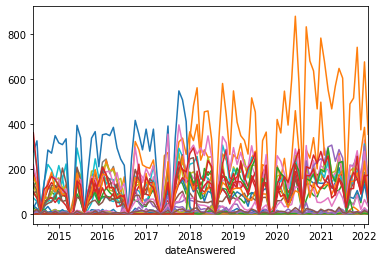

In [43]:
wpqs_dept_lab.pivot(columns='answeringBodyName', values='id').resample('M').sum().plot(legend=False)

<AxesSubplot:xlabel='dateAnswered', ylabel='id'>

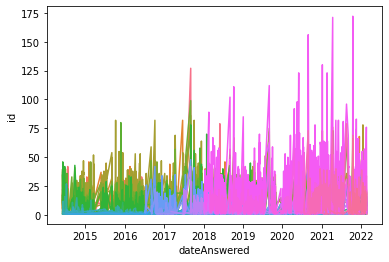

In [45]:
sns.lineplot(data=wpqs_dept_lab.reset_index(), x='dateAnswered', y='id', hue='answeringBodyName', legend=False)